# myrun

This notebook imports the feature vector, merges it with the labelled data and then makes predictions on specified columns


In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
from functools import reduce

# Igel
from igel import Igel

# Compare Algorithms
import matplotlib.pyplot as plt
from matplotlib import rcParams

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
def clean_dataset_int(df):
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    df.replace(np.nan,0)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    df = df.replace(r'\D+', '', regex=True)
    return df[indices_to_keep].astype(np.float64)

In [3]:
# Set the column names
feature_vector_keys = ["timestamp", #0
                       "tweet_id",  
                       "positive_sentiment", 
                       "negative_sentiment", 
                       "numb_of_mentions", 
                       "numb_of_media",
                       "numb_of_urls", 
                       "numb_of_hashtags", 
                       "numb_of_personal_pronouns", 
                       "numb_of_present_tenses", 
                       "numb_of_past_tenses", #10 
                       #"sent_from_web",
                       "numb_of_named_entites",
                       "numb_of_weird_chars", 
                       "numb_of_questions", 
                       "numb_of_emoticons", 
                       "numb_of_swearing_words", 
                       "numb_of_slang_words", 
                       "numb_of_intensifiers", 
                       "tweet_length", 
                       "userFollowersCount",
                       "userFriendsCount", #20
                       "user_numb_of_tweets",
                       "user_list_count",
                       #"tfidf_fire",                      # old
                       "dict_precision",                  # measures against the keyword TFIDF
                       "dict_recall", 
                       "dict_f_measure",
                       "offset",
                       "weighted_length", # the overall length of the Tweet with code points weighted per the ranges
                       "permillage", # (indicates the proportion (per thousand) of the weighted length in comparison to the max weighted length.
                       "is_verified", # column 29  #30 Non-word-embedding-features (0-29)
                       "wEmbed1",
                       "wEmbed2",
                       "wEmbed3",
                       "wEmbed4",
                       "wEmbed5",
                       "wEmbed6",
                       "wEmbed7",
                       "wEmbed8",
                       "wEmbed9",
                       "wEmbed10",
                       "wEmbed11",
                       "wEmbed12",
                       "wEmbed13",
                       "wEmbed14",
                       "wEmbed15",
                       "wEmbed16",
                       "wEmbed17",
                       "wEmbed18",
                       "wEmbed19",
                       "wEmbed20",
                       "wEmbed21",
                       "wEmbed22",
                       "wEmbed23",
                       "wEmbed24",
                       "wEmbed25",
                       "wEmbed26",
                       "wEmbed27",
                       "wEmbed28",
                       "wEmbed29",
                       "wEmbed30",
                       "wEmbed31",
                       "wEmbed32",
                       "wEmbed33",
                       "wEmbed34",
                       "wEmbed35",
                       "wEmbed36",
                       "wEmbed37",
                       "wEmbed38",
                       "wEmbed39",
                       "wEmbed40",
                       "wEmbed41",
                       "wEmbed42",
                       "wEmbed43",
                       "wEmbed44",
                       "wEmbed45",
                       "wEmbed46",
                       "wEmbed47",
                       "wEmbed48",
                       "wEmbed49",
                       "wEmbed51",
                       "wEmbed52",
                       "wEmbed53",
                       "wEmbed54",
                       "wEmbed55",
                       "wEmbed56",
                       "wEmbed57",
                       "wEmbed58",
                       "wEmbed59",
                       "wEmbed60",
                       "wEmbed61",
                       "wEmbed62",
                       "wEmbed63",
                       "wEmbed64",
                       "wEmbed65",
                       "wEmbed66",
                       "wEmbed67",
                       "wEmbed68",
                       "wEmbed69",
                       "wEmbed70",
                       "wEmbed71",
                       "wEmbed72",
                       "wEmbed73",
                       "wEmbed74",
                       "wEmbed75",
                       "wEmbed76",
                       "wEmbed77",
                       "wEmbed78",
                       "wEmbed79",
                       "wEmbed80",
                       "wEmbed81",
                       "wEmbed82",
                       "wEmbed83",
                       "wEmbed84",
                       "wEmbed85",
                       "wEmbed86",
                       "wEmbed87",
                       "wEmbed88",
                       "wEmbed89",
                       "wEmbed80",
                       "wEmbed91",
                       "wEmbed92",
                       "wEmbed93",
                       "wEmbed94",
                       "wEmbed95",
                       "wEmbed96",
                       "wEmbed97",
                       "wEmbed98",
                       "wEmbed99",
                       "wEmbed99",
                       "wEmbed100"
                       ]


priority_scorer = {
    '10' : 'Critical',
    '9' : 'Critical',
    '8' : 'Critical',
    '7' : 'High',
    '6' : 'High',
    '5' : 'Medium',
    '4' : 'Medium',
    '3' : 'Low',
    '2' : 'Low',
    '1.0' : 'Low',
    '0.0' : 'Low',
}

priority_mapping = {
    "Critical" : 10,
    "High" : 7.5,
    "Medium" : 5,
    "Low" : 2.5,
    "Unknown" : 0,
}

# What we consider to be highly important categories of information
highCategoriser = {
    0.0 : 'Other-Advice',
    1.0 : 'Other-Advice',
    2.0 : 'Report-CleanUp',
    3.0 : 'ContextualInformation',
    4.0 : 'Other-ContextualInformation',
    5.0 : 'CallToAction-Donations',
    6.0 : 'Report-EmergingThreats',
    7.0 : 'Report-Factoid',
    8.0 : 'Report-FirstPartyObservation',
    9.0 : 'Request-GoodsServices',
    10.0 : 'Report-Hashtags',
    11.0 : 'Request-InformationWanted',
    12.0 : 'Other-Irrelevant',
    13.0 : 'Report-Location',
    14.0 : 'CallToAction-MovePeople',
    15.0 : 'Report-MultimediaShare',
    16.0 : 'Report-NewSubEvent',
    17.0 : 'Report-News',
    18.0 : 'Report-Official',
    19.0 : 'Report-OriginalEvent',
    20.0 : 'Request-SearchAndRescue',
    21.0 : 'Other-Sentiment',
    22.0 : 'Report-ServiceAvailable',
    23.0 : 'Report-ThirdPartyObservation',
    24.0 : 'CallToAction-Volunteer',
    25.0 : 'Report-Weather',
    26.0 : 'hmm',
}

event_int_map =	{
  "guatemalaEarthquake2012": 7,
  "joplinTornado2011": 16,
  "athensEarthquake2020": 35,
  "baltimoreFlashFlood2020": 36,
  "brooklynBlockPartyShooting2020": 37,
  "daytonOhioShooting2020": 38,
  "elPasoWalmartShooting2020": 39,
  "gilroygarlicShooting2020": 40,
  "hurricaneBarry2020": 41,
  "indonesiaEarthquake2020": 42,
  "keralaFloods2020": 43,
  "myanmarFloods2020": 44,
  "papuaNewguineaEarthquake2020": 45,
  "siberianWildfires2020": 46,
  "typhoonKrosa2020": 47,
  "typhoonLekima2020": 48,
  "whaleyBridgeCollapse2020": 49
}

mymap = {'Advice':1, 'CleanUp':2, 'ContextualInformation':3, 'Discussion':4, 'Donations':5, 
        'EmergingThreats':6, 'Factoid':7, 'FirstPartyObservation':8, 'GoodsServices':9, 'Hashtags':10, 
        'InformationWanted':11,'Irrelevant':12, 'Location':13, 'MovePeople':14, 
         'MultimediaShare':15, 'NewSubEvent':16, 'News':17,
        'Official':18, 'OriginalEvent':19, 'SearchAndRescue':20, 'Sentiment':21, 'ServiceAvailable':22, 
         'ThirdPartyObservation':23,'Volunteer':24, 'Weather':25}

## Feature Vector

Load the feature vector in from Play

In [4]:
# Currently loading the feature vector from a .txt file exported from Play
feature_vector_input = pd.read_csv("../../../0-data/processed/brand_new_run2.txt", sep=",", header=None, error_bad_lines=False)
# Remove superflous "]"
del feature_vector_input[130]
feature_vector_input


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129
0,[1.564909485E12,1.157940e+18,3.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,5.0,0.0,0.0,0.0,0.0,0.0,27.0,4993.0,5386.0,0.0,15.0,0.0,0.0,0.0,32666.0,27.0,96.0,0.0],[-0.24360474944114685,0.558520,1.178674,-3.819361,-0.872806,1.975013,-0.199801,1.908640,-3.058102,-0.800329,0.063198,-1.264392,0.469776,1.295378,0.612870,-2.508894,1.753001,1.636335,-0.968230,1.211253,1.591384,0.427036,1.301443,0.361770,1.998500,1.030800,0.131714,-3.271060,2.637650,0.381060,-0.187249,4.560800,1.075122,1.477030,0.144370,1.810591,-0.952863,1.966870,1.790676,-1.032249,1.866919,-1.808300,-0.770760,-2.632084,-2.265749,-0.508120,-0.882499,-1.788940,-0.169399,-3.560888,-0.637511,0.293910,1.869815,2.528408,-1.112830,-13.003301,-1.463077,-0.300350,7.550340,1.588357,-2.544071,4.590492,-1.743418,-2.590050,3.885296,0.106120,3.917640,1.284417,0.467890,1.206738,0.110660,-1.116088,-2.919050,-2.261258,0.953257,-0.061070,0.352852,0.504343,-2.638044,0.051571,2.681230,-1.020494,-2.661110,1.298850,-6.262980,0.715867,-1.182339,-2.271639,-0.596980,1.261390,0.535032,-1.982783,0.497030,-0.133010,-3.305418,0.605830,-1.322281,-0.551913,2.405710,0.006743
1,[1.565125769E12,1.158848e+18,20.0,14.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,9.0,1.0,0.0,0.0,0.0,0.0,46.0,11344.0,11196.0,0.0,217.0,0.0,0.0,0.0,248950.0,46.0,164.0,0.0],[-0.8654940128326416,1.089764,6.069625,-6.451960,-0.128560,2.401099,0.724843,2.246320,2.089268,0.160001,1.238298,-0.599819,1.523069,-0.454055,2.074487,-1.692290,1.522726,1.271118,-2.986836,1.564884,2.801068,-0.141592,0.571308,0.440946,3.181582,0.848406,0.180744,-5.237364,0.359668,0.043784,-1.307540,8.139876,-0.295631,1.705730,1.510064,3.238868,-1.204458,1.013880,-0.712210,-2.890312,-3.377252,-1.018287,0.304806,-3.872520,-2.593705,-1.305687,3.499629,-4.491268,-1.592140,-4.883700,2.264805,0.263586,2.837553,6.580034,-5.000520,-23.804832,-0.582326,-0.331671,14.742210,4.627980,-1.856470,5.959161,-1.794688,-2.138013,7.622664,-2.311998,5.101449,4.158309,1.592891,-0.157447,0.015614,-3.098657,0.744229,-3.361730,2.957714,-0.205423,1.837122,0.559743,-10.022050,0.278336,4.886600,-1.258811,-6.247366,1.722133,-10.655029,-2.105281,-0.338242,-3.061087,-0.492044,-1.328935,-1.148220,-3.369777,-0.244400,1.645665,-2.854131,0.921839,-0.605652,-2.701260,3.897667,2.284336
2,[1.564879438E12,1.157814e+18,9.0,26.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,11.0,3.0,0.0,0.0,0.0,0.0,46.0,54.0,58.0,0.0,0.0,0.0,0.0,0.0,2619.0,46.0,164.0,0.0],[0.17969101667404175,5.744810,5.850665,-6.884667,-2.924710,3.669719,0.253575,0.751900,1.053774,-1.932998,2.343533,-1.800562,2.023466,1.060038,1.601493,-4.950460,1.060014,2.923698,-7.589740,5.330271,1.437903,0.844573,-0.686096,-2.052728,3.148350,1.777339,-2.212323,-7.197795,1.898860,-2.563859,-0.229020,7.282259,1.889423,1.483025,-0.676904,3.831918,-1.797647,4.177440,2.244830,-3.176969,-3.017236,-2.664260,-0.544856,-7.324630,-4.184103,-1.678459,1.275782,-5.448890,-2.864620,-8.082760,-1.343282,-1.043030,0.234533,12.295759,-2.814060,-25.681503,1.788334,-0.884634,17.722870,5.188790,-3.971531,9.499792,-2.943453,-1.256906,8.952637,1.210914,6.458437,4.227636,0.764555,-1.951705,1.171300,-3.618505,-2.123201,-4.123644,2.172931,1.125528,0.232227,0.745484,-9.799858,-0.997419,7.145360,-0.765529,-5.985370,0.884670,-15.895481,-0.313303,-0.420867,-2.685760,-3.423290,-3.596541,0.169108,-2.635430,1.625559,-1.503975,-8.070729,1.353070,-0.403625,-3.328030,4.730428,3.041474
3,[1.56510874E12,1.158776e+18,3.0,58.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,37.0,179.0,202.0,0.0,1.0,0.0,0.0,0.0,231921.0,37.0,132.0,0.0],[0.3303939998149872,0.436693,3.436750,-3.454991,-2.430940,0.8475

In [5]:



# Set the column names
feature_vector_input.columns = feature_vector_keys


feature_vector_input.describe()
feature_vector_input

,timestamp,tweet_id,positive_sentiment,negative_sentiment,numb_of_mentions,numb_of_media,numb_of_urls,numb_of_hashtags,numb_of_personal_pronouns,numb_of_present_tenses,numb_of_past_tenses,numb_of_named_entites,numb_of_weird_chars,numb_of_questions,numb_of_emoticons,numb_of_swearing_words,numb_of_slang_words,numb_of_intensifiers,tweet_length,userFollowersCount,userFriendsCount,user_numb_of_tweets,user_list_count,dict_precision,dict_recall,dict_f_measure,offset,weighted_length,permillage,is_verified,wEmbed1,wEmbed2,wEmbed3,wEmbed4,wEmbed5,wEmbed6,wEmbed7,wEmbed8,wEmbed9,wEmbed10,wEmbed11,wEmbed12,wEmbed13,wEmbed14,wEmbed15,wEmbed16,wEmbed17,wEmbed18,wEmbed19,wEmbed20,wEmbed21,wEmbed22,wEmbed23,wEmbed24,wEmbed25,wEmbed26,wEmbed27,wEmbed28,wEmbed29,wEmbed30,wEmbed31,wEmbed32,wEmbed33,wEmbed34,wEmbed35,wEmbed36,wEmbed37,wEmbed38,wEmbed39,wEmbed40,wEmbed41,wEmbed42,wEmbed43,wEmbed44,wEmbed45,wEmbed46,wEmbed47,wEmbed48,wEmbed49,wEmbed51,wEmbed52,wEmbed53,wEmbed54,wEmbed55,wEmbed56,wEmbed57,wEmbed58,wEmbed59,wEmbed60,wEmbed61,wEmbed62,wEmbed63,wEmbed64,wEmbed65,wEmbed66,wEmbed67,wEmbed68,wEmbed69,wEmbed70,wEmbed71,wEmbed72,wEmbed73,wEmbed74,wEmbed75,wEmbed76,wEmbed77,wEmbed78,wEmbed79,wEmbed80,wEmbed81,wEmbed82,wEmbed83,wEmbed84,wEmbed85,wEmbed86,wEmbed87,wEmbed88,wEmbed89,wEmbed80,wEmbed91,wEmbed92,wEmbed93,wEmbed94,wEmbed95,wEmbed96,wEmbed97,wEmbed98,wEmbed99,wEmbed99,wEmbed100
0,[1.564909485E12,1.157940e+18,3.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,5.0,0.0,0.0,0.0,0.0,0.0,27.0,4993.0,5386.0,0.0,15.0,0.0,0.0,0.0,32666.0,27.0,96.0,0.0],[-0.24360474944114685,0.558520,1.178674,-3.819361,-0.872806,1.975013,-0.199801,1.908640,-3.058102,-0.800329,0.063198,-1.264392,0.469776,1.295378,0.612870,-2.508894,1.753001,1.636335,-0.968230,1.211253,1.591384,0.427036,1.301443,0.361770,1.998500,1.030800,0.131714,-3.271060,2.637650,0.381060,-0.187249,4.560800,1.075122,1.477030,0.144370,1.810591,-0.952863,1.966870,1.790676,-1.032249,1.866919,-1.808300,-0.770760,-2.632084,-2.265749,-0.508120,-0.882499,-1.788940,-0.169399,-3.560888,-0.637511,0.293910,1.869815,2.528408,-1.112830,-13.003301,-1.463077,-0.300350,7.550340,1.588357,-2.544071,4.590492,-1.743418,-2.590050,3.885296,0.106120,3.917640,1.284417,0.467890,1.206738,0.110660,-1.116088,-2.919050,-2.261258,0.953257,-0.061070,0.352852,0.504343,-2.638044,0.051571,2.681230,-1.020494,-2.661110,1.298850,-6.262980,0.715867,-1.182339,-2.271639,-0.596980,1.261390,0.535032,-1.982783,0.497030,-0.133010,-3.305418,0.605830,-1.322281,-0.551913,2.405710,0.006743
1,[1.565125769E12,1.158848e+18,20.0,14.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,9.0,1.0,0.0,0.0,0.0,0.0,46.0,11344.0,11196.0,0.0,217.0,0.0,0.0,0.0,248950.0,46.0,164.0,0.0],[-0.8654940128326416,1.089764,6.069625,-6.451960,-0.128560,2.401099,0.724843,2.246320,2.089268,0.160001,1.238298,-0.599819,1.523069,-0.454055,2.074487,-1.692290,1.522726,1.271118,-2.986836,1.564884,2.801068,-0.141592,0.571308,0.440946,3.181582,0.848406,0.180744,-5.237364,0.359668,0.043784,-1.307540,8.139876,-0.295631,1.705730,1.510064,3.238868,-1.204458,1.013880,-0.712210,-2.890312,-3.377252,-1.018287,0.304806,-3.872520,-2.593705,-1.305687,3.499629,-4.491268,-1.592140,-4.883700,2.264805,0.263586,2.837553,6.580034,-5.000520,-23.804832,-0.582326,-0.331671,14.742210,4.627980,-1.856470,5.959161,-1.794688,-2.138013,7.622664,-2.311998,5.101449,4.158309,1.592891,-0.157447,0.015614,-3.098657,0.744229,-3.361730,2.957714,-0.205423,1.837122,0.559743,-10.022050,0.278336,4.886600,-1.258811,-6.247366,1.722133,-10.655029,-2.105281,-0.338242,-3.061087,-0.492044,-1.328935,-1.148220,-3.369777,-0.244400,1.645665,-2.854131,0.921839,-0.605652,-2.701260,3.897667,2.284336
2,[1.564879438E12,1.157814e+18,9.0,26.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,11.0,3.0,0.0,0.0,0.0,0.0,46.0,54.0,58.0,0.0,0.0,0.0,0.0,0.0,2619.0,46.0,164.0,0.0],[0.17969101667404175,5.744810,5.850665,-6.884667,-2.924710,3.669719,0.253575,0.751900,1.053774,-1.932998,2.343533,-1.800562,2.023466,1.060038,1.601493,-4.950460,1.060014,2.923698,-7.589740,5.330271,1.4379

In [6]:
# Group by tweet
feature_vector_input = feature_vector_input.groupby(['tweet_id']).agg('first')

# Reset the index
feature_vector_input.reset_index(level=0, inplace=True)

# Create a numeric version for our model
feature_vector_input = clean_dataset_int(feature_vector_input)

feature_vector_input.describe()
feature_vector_input

,tweet_id,timestamp,positive_sentiment,negative_sentiment,numb_of_mentions,numb_of_media,numb_of_urls,numb_of_hashtags,numb_of_personal_pronouns,numb_of_present_tenses,numb_of_past_tenses,numb_of_named_entites,numb_of_weird_chars,numb_of_questions,numb_of_emoticons,numb_of_swearing_words,numb_of_slang_words,numb_of_intensifiers,tweet_length,userFollowersCount,userFriendsCount,user_numb_of_tweets,user_list_count,dict_precision,dict_recall,dict_f_measure,offset,weighted_length,permillage,is_verified,wEmbed1,wEmbed2,wEmbed3,wEmbed4,wEmbed5,wEmbed6,wEmbed7,wEmbed8,wEmbed9,wEmbed10,wEmbed11,wEmbed12,wEmbed13,wEmbed14,wEmbed15,wEmbed16,wEmbed17,wEmbed18,wEmbed19,wEmbed20,wEmbed21,wEmbed22,wEmbed23,wEmbed24,wEmbed25,wEmbed26,wEmbed27,wEmbed28,wEmbed29,wEmbed30,wEmbed31,wEmbed32,wEmbed33,wEmbed34,wEmbed35,wEmbed36,wEmbed37,wEmbed38,wEmbed39,wEmbed40,wEmbed41,wEmbed42,wEmbed43,wEmbed44,wEmbed45,wEmbed46,wEmbed47,wEmbed48,wEmbed49,wEmbed51,wEmbed52,wEmbed53,wEmbed54,wEmbed55,wEmbed56,wEmbed57,wEmbed58,wEmbed59,wEmbed60,wEmbed61,wEmbed62,wEmbed63,wEmbed64,wEmbed65,wEmbed66,wEmbed67,wEmbed68,wEmbed69,wEmbed70,wEmbed71,wEmbed72,wEmbed73,wEmbed74,wEmbed75,wEmbed76,wEmbed77,wEmbed78,wEmbed79,wEmbed80,wEmbed81,wEmbed82,wEmbed83,wEmbed84,wEmbed85,wEmbed86,wEmbed87,wEmbed88,wEmbed89,wEmbed80,wEmbed91,wEmbed92,wEmbed93,wEmbed94,wEmbed95,wEmbed96,wEmbed97,wEmbed98,wEmbed99,wEmbed99,wEmbed100
0,1.128285e+18,1.557839e+11,1.0,58.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,58.0,0.0,0.0,0.0,0.0,0.0,143.0,4416.0,4860.0,0.0,29.0,0.0,0.0,0.0,0.0,219.0,782.0,0.0,5.968614e+15,6.146475,8.715341,-1.991922,-0.351963,-0.451744,6.785281,7.380511,-7.820129,2.053792,17.091467,-5.470624,-4.234895,0.373578,13.441857,-6.727347,1.900836,0.912474,-12.505997,7.738014,9.255160,0.748075,8.408113,14.142615,5.872004,4.713293,7.696070,1.205510,-0.625085,-2.485504,1.133557,10.558162,-2.520868,-5.298311,-0.970177,0.544318,7.618617,2.840050,-1.566092,2.926218,-2.275135,-10.133841,2.291610,-9.230691,1.446731,-2.699489,-1.320471,-7.633193,6.265549,-7.720406,-5.284856,-5.151668,2.538640,14.616082,-12.050274,-50.041180,-4.970889,-4.703255,30.595259,13.804686,-7.798156,11.484619,-6.576855,-1.642147,8.724854,8.149764,-2.864067,5.883440,14.889380,0.987254,-8.867044,-1.229089,-1.699796,1.096596,3.772463,-3.963857,4.063219,1.077463,-16.728254,-8.252973,11.326945,-9.242027,-8.672696,1.721727,-8.613218,-1.279744,6.155481,-3.753160,1.814915,4.303952,-1.283510,8.548613,-2.040404,4.490602,-15.896705,6.662505,-0.935754,-7.028077,8.826044,-5.268056
1,1.128286e+18,1.557839e+11,3.0,63.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,35.0,0.0,0.0,0.0,0.0,0.0,96.0,2420.0,490.0,0.0,11.0,0.0,0.0,0.0,43.0,139.0,496.0,0.0,4.277349e+14,3.597235,5.935533,-0.754512,-1.537063,-2.765388,4.684699,3.829117,-5.308341,2.076718,9.866366,-3.630719,-2.097720,1.889193,6.951647,-2.092314,1.335329,-0.908851,-9.180659,5.087513,7.215860,-0.372905,5.149060,8.908577,2.208687,-0.148569,6.248541,-0.182975,0.054993,-1.186222,2.530330,5.600512,-1.669524,-1.752441,-2.641367,0.608652,5.913237,2.146552,-0.914501,2.382794,-4.152746,-6.751720,2.666150,-5.485946,2.284932,-2.029019,-1.016241,-4.859752,3.303750,-6.627320,-2.375363,-3.205000,2.780918,10.428420,-8.010610,-33.699783,-3.167318,-2.695005,21.709141,8.762173,-5.031306,5.530068,-6.395035,-0.828601,7.407638,6.756029,-4.173906,5.480220,10.068856,2.458073,-5.977562,-1.462001,-3.343237,1.469293,4.065490,-2.923967,3.161891,1.342095,-13.179148,-4.633003,6.488094,-4.677571,-6.385100,0.484432,-7.178493,-2.581191,2.921711,-4.115003,-0.603709,2.494012,-1.434295,3.442343,-0.764550,2.827672,-10.136077,5.757184,-1.030941,-5.725888,5.520404,-3.122853
2,1.128286e+18,1.557839e+11,1.0,58.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,59.0,0.0,0.0,0.0,0.0,0.0,144.0,232.0,841.0,0.0,1.0,0.0,0.0,0.0,49.0,220.0,785.0,0.0,5.968614e+15,6.146475,8.715341,-1.991922,-0.351963,-0.451744,6.785281,7.380511,-7.820129,2.053792,17.091467,-5.470624,-4.234895,0.373578,13.441857,-6.727347,1.900836,0.912474,-12.505997,7.738014,9.255160,0.748075,

## Load the labelled data

These are generated in 0_Labels.ipynb

In [7]:
# dtypes needs to be specified or long ints will change
labels_df = pd.read_json("../../../0-data/raw/data/2020/2020-A/labels/TRECIS-2018-2020A-labels.json", dtype={} )

# replace the event with a numeric value
labels_df = labels_df.replace({'eventID': event_int_map})

# Count the number of labels
labels_df['num'] = labels_df['postCategories'].str.len()


# Map the priority to a numeric value
labels_df = labels_df.replace({"postPriority": priority_mapping})

# Split categories and map to numeric values
category_list = pd.DataFrame(labels_df["postCategories"].to_list(), columns=['cat1', 'cat2', 'cat3',
                                                                   'cat4', 'cat5', 'cat6',
                                                                   'cat7', 'cat8', 'cat9', 'cat10'])


# Map the categories to numeric values
category_list = category_list.applymap(lambda s: mymap.get(s) if s in mymap else s)


# Join back onto our original list
labels = labels_df.join(category_list)

# Drop the string categories
labels.drop(['postCategories'], axis = 1, inplace = True)

# Tidy
labels = labels.drop(['eventName', 'eventDescription', 'eventType'], axis=1)


# Fill the NaN slots with 0
labels = labels.fillna("0")

# Export
labels.to_csv("../3-csv/labels.csv", index=False)

labels = clean_dataset_int(labels)

labels

,eventID,postID,postPriority,num,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10
0,16.0,7.267628e+16,2.5,3.0,7.0,10.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,16.0,7.267840e+16,10.0,4.0,22.0,18.0,10.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0
2,16.0,7.268240e+16,2.5,2.0,21.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,16.0,7.269393e+16,5.0,3.0,23.0,10.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,16.0,7.269856e+16,2.5,3.0,23.0,10.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42946,47.0,1.162000e+18,2.5,1.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42947,47.0,1.162005e+18,2.5,3.0,13.0,15.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42948,47.0,1.162005e+18,2.5,2.0,13.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42949,47.0,1.162006e+18,2.5,3.0,13.0,15.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Train.csv


Merges the input feature vector with the labels

In [8]:
#dfs = [labels, feature_vector_input]
#train = reduce(lambda left,right: pd.merge(left = 'tweet_id', right = 'postID'), dfs)

train = pd.merge(labels, feature_vector_input, left_on = 'postID', right_on = 'tweet_id', how = 'inner')

train.to_csv("../3-csv/train.csv", index=False)

train

,eventID,postID,postPriority,num,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,tweet_id,timestamp,positive_sentiment,negative_sentiment,numb_of_mentions,numb_of_media,numb_of_urls,numb_of_hashtags,numb_of_personal_pronouns,numb_of_present_tenses,numb_of_past_tenses,numb_of_named_entites,numb_of_weird_chars,numb_of_questions,numb_of_emoticons,numb_of_swearing_words,numb_of_slang_words,numb_of_intensifiers,tweet_length,userFollowersCount,userFriendsCount,user_numb_of_tweets,user_list_count,dict_precision,dict_recall,dict_f_measure,offset,weighted_length,permillage,is_verified,wEmbed1,wEmbed2,wEmbed3,wEmbed4,wEmbed5,wEmbed6,wEmbed7,wEmbed8,wEmbed9,wEmbed10,wEmbed11,wEmbed12,wEmbed13,wEmbed14,wEmbed15,wEmbed16,wEmbed17,wEmbed18,wEmbed19,wEmbed20,wEmbed21,wEmbed22,wEmbed23,wEmbed24,wEmbed25,wEmbed26,wEmbed27,wEmbed28,wEmbed29,wEmbed30,wEmbed31,wEmbed32,wEmbed33,wEmbed34,wEmbed35,wEmbed36,wEmbed37,wEmbed38,wEmbed39,wEmbed40,wEmbed41,wEmbed42,wEmbed43,wEmbed44,wEmbed45,wEmbed46,wEmbed47,wEmbed48,wEmbed49,wEmbed51,wEmbed52,wEmbed53,wEmbed54,wEmbed55,wEmbed56,wEmbed57,wEmbed58,wEmbed59,wEmbed60,wEmbed61,wEmbed62,wEmbed63,wEmbed64,wEmbed65,wEmbed66,wEmbed67,wEmbed68,wEmbed69,wEmbed70,wEmbed71,wEmbed72,wEmbed73,wEmbed74,wEmbed75,wEmbed76,wEmbed77,wEmbed78,wEmbed79,wEmbed80,wEmbed81,wEmbed82,wEmbed83,wEmbed84,wEmbed85,wEmbed86,wEmbed87,wEmbed88,wEmbed89,wEmbed80,wEmbed91,wEmbed92,wEmbed93,wEmbed94,wEmbed95,wEmbed96,wEmbed97,wEmbed98,wEmbed99,wEmbed99,wEmbed100
0,45.0,1.128285e+18,7.5,2.0,13.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.128285e+18,1.557839e+11,1.0,58.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,58.0,0.0,0.0,0.0,0.0,0.0,143.0,4416.0,4860.0,0.0,29.0,0.0,0.0,0.0,0.0,219.0,782.0,0.0,5.968614e+15,6.146475,8.715341,-1.991922,-0.351963,-0.451744,6.785281,7.380511,-7.820129,2.053792,17.091467,-5.470624,-4.234895,0.373578,13.441857,-6.727347,1.900836,0.912474,-12.505997,7.738014,9.255160,0.748075,8.408113,14.142615,5.872004,4.713293,7.696070,1.205510,-0.625085,-2.485504,1.133557,10.558162,-2.520868,-5.298311,-0.970177,0.544318,7.618617,2.840050,-1.566092,2.926218,-2.275135,-10.133841,2.291610,-9.230691,1.446731,-2.699489,-1.320471,-7.633193,6.265549,-7.720406,-5.284856,-5.151668,2.538640,14.616082,-12.050274,-50.041180,-4.970889,-4.703255,30.595259,13.804686,-7.798156,11.484619,-6.576855,-1.642147,8.724854,8.149764,-2.864067,5.883440,14.889380,0.987254,-8.867044,-1.229089,-1.699796,1.096596,3.772463,-3.963857,4.063219,1.077463,-16.728254,-8.252973,11.326945,-9.242027,-8.672696,1.721727,-8.613218,-1.279744,6.155481,-3.753160,1.814915,4.303952,-1.283510,8.548613,-2.040404,4.490602,-15.896705,6.662505,-0.935754,-7.028077,8.826044,-5.268056
1,45.0,1.128286e+18,2.5,2.0,13.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.128286e+18,1.557839e+11,11.0,53.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,32.0,0.0,0.0,0.0,0.0,0.0,78.0,4680.0,4.0,0.0,107.0,0.0,0.0,0.0,65.0,114.0,407.0,0.0,2.088101e+16,4.415725,6.278588,-0.551444,0.865506,-1.320997,1.317309,5.032600,-5.071670,2.873144,3.881158,-2.373865,-0.298636,2.448340,5.574950,-2.924466,3.810249,-1.949026,-5.581503,2.534060,4.168069,1.409570,9.370440,6.085739,4.776735,-2.301228,5.013391,0.700985,0.037092,-0.081846,-2.527152,4.399770,0.781237,-3.554773,-1.916950,-0.448365,3.578880,-0.268090,-3.926500,-1.254020,-4.514870,-3.657678,2.911843,-4.186093,3.851487,2.824620,4.039618,-8.007648,1.092541,-4.204590,-6.068099,0.869407,0.933268,10.594642,-8.083122,-27.765770,-3.002952,-7.595671,16.576580,6.267006,-4.733420,7.474398,-5.491436,-1.575930,7.375504,4.290920,-6.735850,3.048641,7.399846,2.854862,0.018556,-3.153146,-3.573433,-1.594135,1.090870,-0.429310,1.660162,5.180491,-10.804480,-2.194241,8.646333,-0.546895,-1.664736,0.974408,-4.574147,-1.659156,0.534340,0.979816,-1.601412,0.556865,3.114542,0.851060,-1.523430,3.367815,-9.796415,6.970568,-3.508447,-1.758335,3.709830,-3.711423
2,45.0,1.128286e+18,2.5,3.0,13.0,7.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.128286e+18,1.557839e+11,2.0,58.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,4.0,97.0,0.0,0.0,0.0,0.

# Test.csv


Drops the categories, number of categories and priority so we can make our prediction

In [9]:
test = train

# Drop cat*
test.drop(list(test.filter(regex = 'cat')), axis = 1, inplace = True)

# Drop priority / num (of labels)
test.drop(['postPriority', 'num'], axis = 1, inplace = True)

# export
test.to_csv("../3-csv/test.csv", index=False)

test

,eventID,postID,tweet_id,timestamp,positive_sentiment,negative_sentiment,numb_of_mentions,numb_of_media,numb_of_urls,numb_of_hashtags,numb_of_personal_pronouns,numb_of_present_tenses,numb_of_past_tenses,numb_of_named_entites,numb_of_weird_chars,numb_of_questions,numb_of_emoticons,numb_of_swearing_words,numb_of_slang_words,numb_of_intensifiers,tweet_length,userFollowersCount,userFriendsCount,user_numb_of_tweets,user_list_count,dict_precision,dict_recall,dict_f_measure,offset,weighted_length,permillage,is_verified,wEmbed1,wEmbed2,wEmbed3,wEmbed4,wEmbed5,wEmbed6,wEmbed7,wEmbed8,wEmbed9,wEmbed10,wEmbed11,wEmbed12,wEmbed13,wEmbed14,wEmbed15,wEmbed16,wEmbed17,wEmbed18,wEmbed19,wEmbed20,wEmbed21,wEmbed22,wEmbed23,wEmbed24,wEmbed25,wEmbed26,wEmbed27,wEmbed28,wEmbed29,wEmbed30,wEmbed31,wEmbed32,wEmbed33,wEmbed34,wEmbed35,wEmbed36,wEmbed37,wEmbed38,wEmbed39,wEmbed40,wEmbed41,wEmbed42,wEmbed43,wEmbed44,wEmbed45,wEmbed46,wEmbed47,wEmbed48,wEmbed49,wEmbed51,wEmbed52,wEmbed53,wEmbed54,wEmbed55,wEmbed56,wEmbed57,wEmbed58,wEmbed59,wEmbed60,wEmbed61,wEmbed62,wEmbed63,wEmbed64,wEmbed65,wEmbed66,wEmbed67,wEmbed68,wEmbed69,wEmbed70,wEmbed71,wEmbed72,wEmbed73,wEmbed74,wEmbed75,wEmbed76,wEmbed77,wEmbed78,wEmbed79,wEmbed80,wEmbed81,wEmbed82,wEmbed83,wEmbed84,wEmbed85,wEmbed86,wEmbed87,wEmbed88,wEmbed89,wEmbed80,wEmbed91,wEmbed92,wEmbed93,wEmbed94,wEmbed95,wEmbed96,wEmbed97,wEmbed98,wEmbed99,wEmbed99,wEmbed100
0,45.0,1.128285e+18,1.128285e+18,1.557839e+11,1.0,58.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,58.0,0.0,0.0,0.0,0.0,0.0,143.0,4416.0,4860.0,0.0,29.0,0.0,0.0,0.0,0.0,219.0,782.0,0.0,5.968614e+15,6.146475,8.715341,-1.991922,-0.351963,-0.451744,6.785281,7.380511,-7.820129,2.053792,17.091467,-5.470624,-4.234895,0.373578,13.441857,-6.727347,1.900836,0.912474,-12.505997,7.738014,9.255160,0.748075,8.408113,14.142615,5.872004,4.713293,7.696070,1.205510,-0.625085,-2.485504,1.133557,10.558162,-2.520868,-5.298311,-0.970177,0.544318,7.618617,2.840050,-1.566092,2.926218,-2.275135,-10.133841,2.291610,-9.230691,1.446731,-2.699489,-1.320471,-7.633193,6.265549,-7.720406,-5.284856,-5.151668,2.538640,14.616082,-12.050274,-50.041180,-4.970889,-4.703255,30.595259,13.804686,-7.798156,11.484619,-6.576855,-1.642147,8.724854,8.149764,-2.864067,5.883440,14.889380,0.987254,-8.867044,-1.229089,-1.699796,1.096596,3.772463,-3.963857,4.063219,1.077463,-16.728254,-8.252973,11.326945,-9.242027,-8.672696,1.721727,-8.613218,-1.279744,6.155481,-3.753160,1.814915,4.303952,-1.283510,8.548613,-2.040404,4.490602,-15.896705,6.662505,-0.935754,-7.028077,8.826044,-5.268056
1,45.0,1.128286e+18,1.128286e+18,1.557839e+11,11.0,53.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,32.0,0.0,0.0,0.0,0.0,0.0,78.0,4680.0,4.0,0.0,107.0,0.0,0.0,0.0,65.0,114.0,407.0,0.0,2.088101e+16,4.415725,6.278588,-0.551444,0.865506,-1.320997,1.317309,5.032600,-5.071670,2.873144,3.881158,-2.373865,-0.298636,2.448340,5.574950,-2.924466,3.810249,-1.949026,-5.581503,2.534060,4.168069,1.409570,9.370440,6.085739,4.776735,-2.301228,5.013391,0.700985,0.037092,-0.081846,-2.527152,4.399770,0.781237,-3.554773,-1.916950,-0.448365,3.578880,-0.268090,-3.926500,-1.254020,-4.514870,-3.657678,2.911843,-4.186093,3.851487,2.824620,4.039618,-8.007648,1.092541,-4.204590,-6.068099,0.869407,0.933268,10.594642,-8.083122,-27.765770,-3.002952,-7.595671,16.576580,6.267006,-4.733420,7.474398,-5.491436,-1.575930,7.375504,4.290920,-6.735850,3.048641,7.399846,2.854862,0.018556,-3.153146,-3.573433,-1.594135,1.090870,-0.429310,1.660162,5.180491,-10.804480,-2.194241,8.646333,-0.546895,-1.664736,0.974408,-4.574147,-1.659156,0.534340,0.979816,-1.601412,0.556865,3.114542,0.851060,-1.523430,3.367815,-9.796415,6.970568,-3.508447,-1.758335,3.709830,-3.711423
2,45.0,1.128286e+18,1.128286e+18,1.557839e+11,2.0,58.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,4.0,97.0,0.0,0.0,0.0,0.0,0.0,208.0,13.0,50.0,0.0,0.0,0.0,0.0,0.0,207.0,235.0,839.0,0.0,8.283619e+15,7.540946,11.193747,3.443854,-2.476866,1.830950,5.891050,7.254282,-7.793662,1.874855,15.142878,-2.135001,-0.102999,-0.073599,13.831659,-6.63

## Igel

This notebook implements `Igel`

> Igel supports all sklearn's machine learning functionality,

Igel's supported models:

        +--------------------+----------------------------+-------------------------+
        |      regression    |        classification      |        clustering       |
        +--------------------+----------------------------+-------------------------+
        |   LinearRegression |         LogisticRegression |                  KMeans |
        |              Lasso |                      Ridge |     AffinityPropagation |
        |          LassoLars |               DecisionTree |                   Birch |
        | BayesianRegression |                  ExtraTree | AgglomerativeClustering |
        |    HuberRegression |               RandomForest |    FeatureAgglomeration |
        |              Ridge |                 ExtraTrees |                  DBSCAN |
        |  PoissonRegression |                        SVM |         MiniBatchKMeans |
        |      ARDRegression |                  LinearSVM |    SpectralBiclustering |
        |  TweedieRegression |                      NuSVM |    SpectralCoclustering |
        | TheilSenRegression |            NearestNeighbor |      SpectralClustering |
        |    GammaRegression |              NeuralNetwork |               MeanShift |
        |   RANSACRegression | PassiveAgressiveClassifier |                  OPTICS |
        |       DecisionTree |                 Perceptron |                    ---- |
        |          ExtraTree |               BernoulliRBM |                    ---- |
        |       RandomForest |           BoltzmannMachine |                    ---- |
        |         ExtraTrees |       CalibratedClassifier |                    ---- |
        |                SVM |                   Adaboost |                    ---- |
        |          LinearSVM |                    Bagging |                    ---- |
        |              NuSVM |           GradientBoosting |                    ---- |
        |    NearestNeighbor |        BernoulliNaiveBayes |                    ---- |
        |      NeuralNetwork |      CategoricalNaiveBayes |                    ---- |
        |         ElasticNet |       ComplementNaiveBayes |                    ---- |
        |       BernoulliRBM |         GaussianNaiveBayes |                    ---- |
        |   BoltzmannMachine |      MultinomialNaiveBayes |                    ---- |
        |           Adaboost |                       ---- |                    ---- |
        |            Bagging |                       ---- |                    ---- |
        |   GradientBoosting |                       ---- |                    ---- |
        +--------------------+----------------------------+-------------------------+

### Fit



In [10]:
params = {
        'cmd': 'fit',    # provide the command you want to use. whether fit, evaluate or predict
        'data_path': "../3-csv/train.csv",
        'yaml_path': 'yaml/multi.yaml'  # DecisionTree
}

Igel(**params)

INFO - Entered CLI args: {'cmd': 'fit', 'data_path': '../3-csv/train.csv', 'yaml_path': 'yaml/multi.yaml'}
INFO - Executing command: fit ...
INFO - reading data from ../3-csv/train.csv
INFO - You passed the configurations as a yaml file.
INFO - your chosen configuration: {'dataset': {'split': {'test_size': 0.2, 'shuffle': True, 'stratify': 'default', 'scale': {'method': 'standard', 'target': 'inputs'}}}, 'model': {'type': 'regression', 'algorithm': 'DecisionTree'}, 'target': ['postPriority', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'cat10', 'num']}
INFO - dataset_props: {'split': {'test_size': 0.2, 'shuffle': True, 'stratify': 'default', 'scale': {'method': 'standard', 'target': 'inputs'}}} 
model_props: {'type': 'regression', 'algorithm': 'DecisionTree'} 
 target: ['postPriority', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'cat10', 'num'] 

INFO - dataset shape: (3883, 144)
INFO - dataset attributes: ['eventID', 'postID', 'po

### Evaluate



In [11]:
params = {
        'cmd': 'evaluate',    
        'data_path': "../3-csv/train.csv",
        'yaml_path': 'yaml/hyper.yaml'


}

Igel(**params)

INFO - Entered CLI args: {'cmd': 'evaluate', 'data_path': '../3-csv/train.csv', 'yaml_path': 'yaml/hyper.yaml'}
INFO - Executing command: evaluate ...
INFO - reading data from ../3-csv/train.csv
INFO - path of the pre-fitted model => /Users/mark/HelpMe-clone/1-src/2-python/2-notebooks/model_results/model.sav
INFO - result path: /Users/mark/HelpMe-clone/1-src/2-python/2-notebooks/model_results 
INFO - loading model form /Users/mark/HelpMe-clone/1-src/2-python/2-notebooks/model_results/model.sav 
INFO - dataset shape: (3883, 144)
INFO - dataset attributes: ['eventID', 'postID', 'postPriority', 'num', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'cat10', 'tweet_id', 'timestamp', 'positive_sentiment', 'negative_sentiment', 'numb_of_mentions', 'numb_of_media', 'numb_of_urls', 'numb_of_hashtags', 'numb_of_personal_pronouns', 'numb_of_present_tenses', 'numb_of_past_tenses', 'numb_of_named_entites', 'numb_of_weird_chars', 'numb_of_questions', 'numb_of_emoticons', 'nu

### Predict



In [12]:
params = {
        'cmd': 'predict',    
        'data_path': "../3-csv/test.csv",
        'yaml_path': 'yaml/hyper.yaml'

}

Igel(**params)

INFO - Entered CLI args: {'cmd': 'predict', 'data_path': '../3-csv/test.csv', 'yaml_path': 'yaml/hyper.yaml'}
INFO - Executing command: predict ...
INFO - reading data from ../3-csv/test.csv
INFO - path of the pre-fitted model => /Users/mark/HelpMe-clone/1-src/2-python/2-notebooks/model_results/model.sav
INFO - loading from /Users/mark/HelpMe-clone/1-src/2-python/2-notebooks/model_results/model.sav
INFO - dataset shape: (3883, 132)
INFO - dataset attributes: ['eventID', 'postID', 'tweet_id', 'timestamp', 'positive_sentiment', 'negative_sentiment', 'numb_of_mentions', 'numb_of_media', 'numb_of_urls', 'numb_of_hashtags', 'numb_of_personal_pronouns', 'numb_of_present_tenses', 'numb_of_past_tenses', 'numb_of_named_entites', 'numb_of_weird_chars', 'numb_of_questions', 'numb_of_emoticons', 'numb_of_swearing_words', 'numb_of_slang_words', 'numb_of_intensifiers', 'tweet_length', 'userFollowersCount', 'userFriendsCount', 'user_numb_of_tweets', 'user_list_count', 'dict_precision', 'dict_recall',

## View the predictions

In [13]:
predictions = pd.read_csv("model_results/predictions.csv")
predictions

def is_neg_predictions(predictions):
    predictions = predictions.sort_values(by=['postPriority'])
    predictions = predictions[(predictions > 0).all(1)]
    predictions.round()
    
#is_neg_predictions(predictions)

### Merge the new predictions back onto dataframe with the missing columns

In [14]:
# Map the labels to their High Level Information Types
cat_list = predictions.filter(regex='cat', axis=1).round().applymap(lambda x: highCategoriser[x])
predictions = cat_list.combine_first(predictions)

# Merge the predictions back into the training set
df = test.merge(predictions, left_index=True, right_index=True)
df.describe()

INFO - NumExpr defaulting to 8 threads.


,eventID,postID,tweet_id,timestamp,positive_sentiment,negative_sentiment,numb_of_mentions,numb_of_media,numb_of_urls,numb_of_hashtags,numb_of_personal_pronouns,numb_of_present_tenses,numb_of_past_tenses,numb_of_named_entites,numb_of_weird_chars,numb_of_questions,numb_of_emoticons,numb_of_swearing_words,numb_of_slang_words,numb_of_intensifiers,tweet_length,userFollowersCount,userFriendsCount,user_numb_of_tweets,user_list_count,dict_precision,dict_recall,dict_f_measure,offset,weighted_length,permillage,is_verified,wEmbed1,wEmbed2,wEmbed3,wEmbed4,wEmbed5,wEmbed6,wEmbed7,wEmbed8,wEmbed9,wEmbed10,wEmbed11,wEmbed12,wEmbed13,wEmbed14,wEmbed15,wEmbed16,wEmbed17,wEmbed18,wEmbed19,wEmbed20,wEmbed21,wEmbed22,wEmbed23,wEmbed24,wEmbed25,wEmbed26,wEmbed27,wEmbed28,wEmbed29,wEmbed30,wEmbed31,wEmbed32,wEmbed33,wEmbed34,wEmbed35,wEmbed36,wEmbed37,wEmbed38,wEmbed39,wEmbed40,wEmbed41,wEmbed42,wEmbed43,wEmbed44,wEmbed45,wEmbed46,wEmbed47,wEmbed48,wEmbed49,wEmbed51,wEmbed52,wEmbed53,wEmbed54,wEmbed55,wEmbed56,wEmbed57,wEmbed58,wEmbed59,wEmbed60,wEmbed61,wEmbed62,wEmbed63,wEmbed64,wEmbed65,wEmbed66,wEmbed67,wEmbed68,wEmbed69,wEmbed70,wEmbed71,wEmbed72,wEmbed73,wEmbed74,wEmbed75,wEmbed76,wEmbed77,wEmbed78,wEmbed79,wEmbed80,wEmbed81,wEmbed82,wEmbed83,wEmbed84,wEmbed85,wEmbed86,wEmbed87,wEmbed88,wEmbed89,wEmbed80,wEmbed91,wEmbed92,wEmbed93,wEmbed94,wEmbed95,wEmbed96,wEmbed97,wEmbed98,wEmbed99,wEmbed99,wEmbed100,num,postPriority
count,3883.000000,3.883000e+03,3.883000e+03,3.883000e+03,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3.883000e+03,3883.000000,3883.0,3883.000000,3883.000000,3883.000000,3883.000000,3.883000e+03,3883.000000,3883.000000,3883.000000,3.883000e+03,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000
mean,43.265774,1.156229e+18,1.156229e+18,1.413868e+11,8.725212,45.989441,0.584342,0.288437,0.640227,0.923255,0.055885,0.289467,0.053309,1.768993,23.660314,0.084471,0.000773,0.000515,0.002833,0.011074,104.976565,1.574543e+05,1812.094772,0.0,659.847025,0.209459,0.114448,0.147816,2.581023e+06,133.419521,476.088591,1.169199,1.279306e+16,2.587030,5.868059,-2.421540,0.589481,1.638703,-0.824581,3.554616,-3.019427,1.459113,3.340256,-1.242124,3.189201,0.404193,3.838073,-4.677126,2.190217,-0.721008,-6.306079,3.819161,6.206324,1.212135,5.412990,4.075075,2.512437,1.329526,-0.934411,-2.694327,0.586231,-1.572350,-0.696143,4.353902,0.552756,2.798092,-2.495616,0.985186,2.089333,1.721767,-0.292448,-0.308083,-6.562608,-4.173616,1.626075,-4.701433,3.276900,-0.054151,2.689269,-4.671872,0.556714,-8.032363,-1.287155,-0.983657,2.067455,13.640705,-4.445254,-32.701940,-0.958730,-3.461440,22.714969,7.812607,-4.096925,10.713018,-3.600663,0.510162,7.579488,2.094856,1.8713

In [15]:
# Append the predicted categories to a list in a new column
df['predicted_categories'] = df[['cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'cat10']].values.tolist()


# Get the number of categories into something we can use to index
df['num'] = df['num'].astype(float).astype(int)

# Remove categories beyond what the tweet is predicted to have
df['categories'] = df.apply(lambda x: x['predicted_categories'][0:x['num']], axis=1)


# Clean
#df = df.filter(['eventID', 'tweet_id', 'postPriority', 'categories'], axis=1).round()

#df = clean_dataset_int(df)
df


,eventID,postID,tweet_id,timestamp,positive_sentiment,negative_sentiment,numb_of_mentions,numb_of_media,numb_of_urls,numb_of_hashtags,numb_of_personal_pronouns,numb_of_present_tenses,numb_of_past_tenses,numb_of_named_entites,numb_of_weird_chars,numb_of_questions,numb_of_emoticons,numb_of_swearing_words,numb_of_slang_words,numb_of_intensifiers,tweet_length,userFollowersCount,userFriendsCount,user_numb_of_tweets,user_list_count,dict_precision,dict_recall,dict_f_measure,offset,weighted_length,permillage,is_verified,wEmbed1,wEmbed2,wEmbed3,wEmbed4,wEmbed5,wEmbed6,wEmbed7,wEmbed8,wEmbed9,wEmbed10,wEmbed11,wEmbed12,wEmbed13,wEmbed14,wEmbed15,wEmbed16,wEmbed17,wEmbed18,wEmbed19,wEmbed20,wEmbed21,wEmbed22,wEmbed23,wEmbed24,wEmbed25,wEmbed26,wEmbed27,wEmbed28,wEmbed29,wEmbed30,wEmbed31,wEmbed32,wEmbed33,wEmbed34,wEmbed35,wEmbed36,wEmbed37,wEmbed38,wEmbed39,wEmbed40,wEmbed41,wEmbed42,wEmbed43,wEmbed44,wEmbed45,wEmbed46,wEmbed47,wEmbed48,wEmbed49,wEmbed51,wEmbed52,wEmbed53,wEmbed54,wEmbed55,wEmbed56,wEmbed57,wEmbed58,wEmbed59,wEmbed60,wEmbed61,wEmbed62,wEmbed63,wEmbed64,wEmbed65,wEmbed66,wEmbed67,wEmbed68,wEmbed69,wEmbed70,wEmbed71,wEmbed72,wEmbed73,wEmbed74,wEmbed75,wEmbed76,wEmbed77,wEmbed78,wEmbed79,wEmbed80,wEmbed81,wEmbed82,wEmbed83,wEmbed84,wEmbed85,wEmbed86,wEmbed87,wEmbed88,wEmbed89,wEmbed80,wEmbed91,wEmbed92,wEmbed93,wEmbed94,wEmbed95,wEmbed96,wEmbed97,wEmbed98,wEmbed99,wEmbed99,wEmbed100,cat1,cat10,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,num,postPriority,predicted_categories,categories
0,45.0,1.128285e+18,1.128285e+18,1.557839e+11,1.0,58.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,58.0,0.0,0.0,0.0,0.0,0.0,143.0,4416.0,4860.0,0.0,29.0,0.0,0.0,0.0,0.0,219.0,782.0,0.0,5.968614e+15,6.146475,8.715341,-1.991922,-0.351963,-0.451744,6.785281,7.380511,-7.820129,2.053792,17.091467,-5.470624,-4.234895,0.373578,13.441857,-6.727347,1.900836,0.912474,-12.505997,7.738014,9.255160,0.748075,8.408113,14.142615,5.872004,4.713293,7.696070,1.205510,-0.625085,-2.485504,1.133557,10.558162,-2.520868,-5.298311,-0.970177,0.544318,7.618617,2.840050,-1.566092,2.926218,-2.275135,-10.133841,2.291610,-9.230691,1.446731,-2.699489,-1.320471,-7.633193,6.265549,-7.720406,-5.284856,-5.151668,2.538640,14.616082,-12.050274,-50.041180,-4.970889,-4.703255,30.595259,13.804686,-7.798156,11.484619,-6.576855,-1.642147,8.724854,8.149764,-2.864067,5.883440,14.889380,0.987254,-8.867044,-1.229089,-1.699796,1.096596,3.772463,-3.963857,4.063219,1.077463,-16.728254,-8.252973,11.326945,-9.242027,-8.672696,1.721727,-8.613218,-1.279744,6.155481,-3.753160,1.814915,4.303952,-1.283510,8.548613,-2.040404,4.490602,-15.896705,6.662505,-0.935754,-7.028077,8.826044,-5.268056,Report-Location,Other-Advice,Report-Factoid,Other-Advice,Other-Advice,Other-Advice,Other-Advice,Other-Advice,Other-Advice,Other-Advice,2,7.5,"[Report-Location, Report-Factoid, Other-Advice...","[Report-Location, Report-Factoid]"
1,45.0,1.128286e+18,1.128286e+18,1.557839e+11,11.0,53.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,32.0,0.0,0.0,0.0,0.0,0.0,78.0,4680.0,4.0,0.0,107.0,0.0,0.0,0.0,65.0,114.0,407.0,0.0,2.088101e+16,4.415725,6.278588,-0.551444,0.865506,-1.320997,1.317309,5.032600,-5.071670,2.873144,3.881158,-2.373865,-0.298636,2.448340,5.574950,-2.924466,3.810249,-1.949026,-5.581503,2.534060,4.168069,1.409570,9.370440,6.085739,4.776735,-2.301228,5.013391,0.700985,0.037092,-0.081846,-2.527152,4.399770,0.781237,-3.554773,-1.916950,-0.448365,3.578880,-0.268090,-3.926500,-1.254020,-4.514870,-3.657678,2.911843,-4.186093,3.851487,2.824620,4.039618,-8.007648,1.092541,-4.204590,-6.068099,0.869407,0.933268,10.594642,-8.083122,-27.765770,-3.002952,-7.595671,16.576580,6.267006,-4.733420,7.474398,-5.491436,-1.575930,7.375504,4.290920,-6.735850,3.048641,7.399846,2.854862,0.018556,-3.153146,-3.573433,-1.594135,1.090870,-0.429310,1.660162,5.180491,-10.804480,-2.194241,8.646333,-0.546895,-1.664736,0.974408,-4.574147,-1.659156,0.534340,0.979816,-1.601412,0.556865,3.114542,0.851060,-1.523430,3.367815,-9.796415,6.970568,-3.508447,-1.758335,3.709830,-3.

## Export

Export in the TRECIS format

In [16]:
#testy = pd.read_csv("../3-csv/testy.csv")
#testy

In [17]:
# write to .run file
with open("marks2.run" , "w") as out_file:
    for row in df.drop_duplicates(subset="tweet_id").itertuples():
        #print("row:", row)
        content = [
            "TRECIS-CTIT-H-Test-0" + str(int(row.eventID)),
            "Q0",          
            np.int64(row.tweet_id),   
            getattr(row, 'Index'),  #ToDo: Fix?
            #row.priority,
            str(priority_scorer[str(round(row.postPriority))[:3]]),  #ToDo: Fix
            row.categories,
            "marksrun2"
        ]
        out_file.write("\t".join([str(x) for x in content]) + "\n")

In [18]:
# Set the figure size
rcParams['figure.figsize'] = 20,10

In [19]:
round(2.5)

2

LogisticRegression: 0.387616 (0.076860)
LinearDiscriminantAnalysis: 0.612408 (0.046162)
KNeighborsClassifier: 0.562959 (0.065860)
DecisionTreeClassifier: 0.598552 (0.080062)
GaussianNB: 0.360337 (0.126828)
SVC: 0.586638 (0.070040)


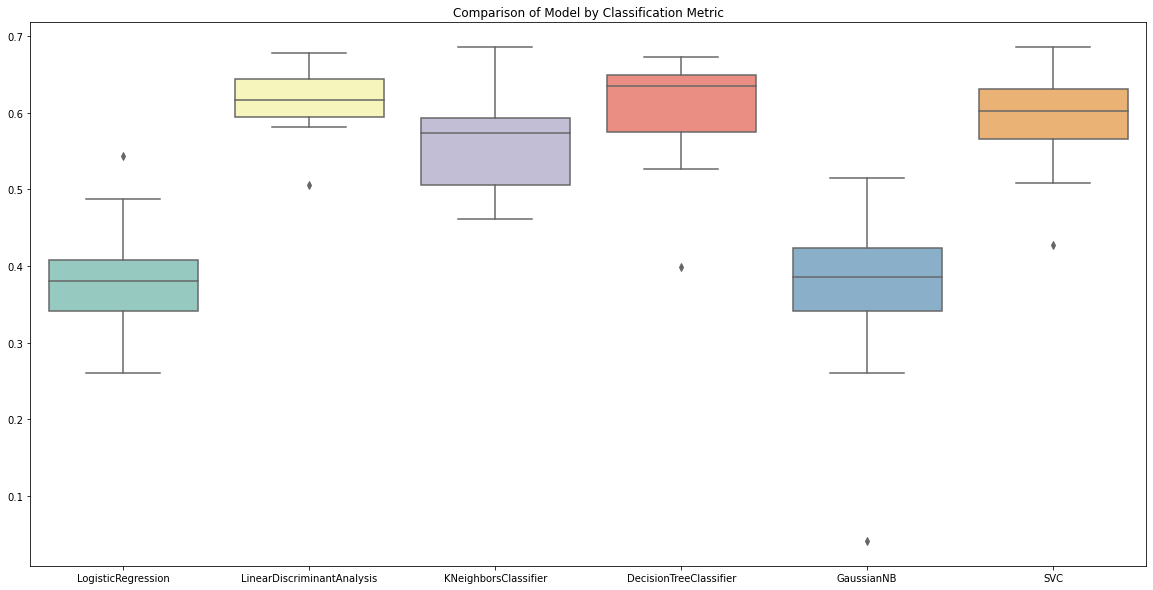

<Figure size 1440x720 with 0 Axes>

In [20]:
# Algorithm Comparison Boxplot

# load dataset
array = train.values
X = array[:,0:8]
Y = array[:,8]

# prepare configuration for cross validation test harness
seed = 7

# prepare models
models = []
models.append(('LogisticRegression', LogisticRegression()))
models.append(('LinearDiscriminantAnalysis', LinearDiscriminantAnalysis()))
models.append(('KNeighborsClassifier', KNeighborsClassifier()))
models.append(('DecisionTreeClassifier', DecisionTreeClassifier()))
models.append(('GaussianNB', GaussianNB()))
models.append(('SVC', SVC()))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# boxplot algorithm comparison
fig = plt.figure()
#fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
#plt.boxplot(results)
sns.boxplot(data=results, palette="Set3")
ax.set_xticklabels(names)
plt.title('Comparison of Model by Classification Metric')
plt.show()

plt.savefig('../../../0-data/screenshots/benchmark_models_performance.png',dpi=300)



In [21]:
# example run
# Run             & NDCG    &  AW-H     & AW-A      & CF1-H   & CF1-A   & CAcc   & PErr-H & PErr-A \\
# njit-sub01.text & 0.4632  & -0.4801   & -0.2493   & 0.0792  & 0.1582  & 0.9025 & 0.1524 & 0.2198 \\